In [124]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from dataset.dataset import create_loaders
from prettytable import PrettyTable
from tqdm import tqdm
import numpy as np
import torch
import gc
import os

In [196]:
sns.set_style("whitegrid")

1. ## Analyzing Amazon-Review Dataset

In [16]:
task='sa'

In [8]:
models = ['bert-base-uncased', 'distilbert-base-uncased', 'roberta-base', 'distilroberta-base']

In [10]:
def create_model(model_name):
    model = AutoModel.from_pretrained(pretrained_model_name_or_path=model_name)
    # freeze the weights
    for param in model.parameters():
        param.requires_grad = False
    return model

In [14]:
model_name = models[0]

In [17]:
tokenizer = AutoTokenizer.from_pretrained(model_name, usefast=True, use_lower_case=True)
loaders = create_loaders(task=task, tokenizer=tokenizer)

Using custom data configuration default
Reusing dataset csv (/home/macab/.cache/huggingface/datasets/csv/default-55a41fe2aee0eb3a/0.0.0/49187751790fa4d820300fd4d0707896e5b941f1a9c644652645b866716a4ac4)
Using custom data configuration default
Reusing dataset csv (/home/macab/.cache/huggingface/datasets/csv/default-54574eb2420d8965/0.0.0/49187751790fa4d820300fd4d0707896e5b941f1a9c644652645b866716a4ac4)
Using custom data configuration default
Reusing dataset csv (/home/macab/.cache/huggingface/datasets/csv/default-b4b36047175548aa/0.0.0/49187751790fa4d820300fd4d0707896e5b941f1a9c644652645b866716a4ac4)
Using custom data configuration default
Reusing dataset csv (/home/macab/.cache/huggingface/datasets/csv/default-6a65ee451571edfc/0.0.0/49187751790fa4d820300fd4d0707896e5b941f1a9c644652645b866716a4ac4)
Using custom data configuration default
Reusing dataset csv (/home/macab/.cache/huggingface/datasets/csv/default-323ff2fd59294775/0.0.0/49187751790fa4d820300fd4d0707896e5b941f1a9c644652645b866

In [41]:
model = create_model(model_name=models[0])


In [94]:

data = {}
for model_name in tqdm(models):

    tokenizer = AutoTokenizer.from_pretrained(model_name, usefast=True, use_lower_case=True)
    loaders = create_loaders(task=task, tokenizer=tokenizer)
    model = create_model(model_name=model_name)

    for domain in tqdm(loaders):
        representation = torch.empty((0, 768))
        for batch in loaders[domain]['valid']:
            
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
            representation = torch.vstack((representation, outputs[0][:, 0]))

            
        if model_name in data.keys():
            data[model_name].update({
                domain:representation
            })
        else:
            data[model_name] = {
                domain:representation
            }

        del representation
        gc.collect()

    del model
    gc.collect()



  0%|          | 0/4 [00:00<?, ?it/s]Using custom data configuration default
Reusing dataset csv (/home/macab/.cache/huggingface/datasets/csv/default-55a41fe2aee0eb3a/0.0.0/49187751790fa4d820300fd4d0707896e5b941f1a9c644652645b866716a4ac4)
Using custom data configuration default
Reusing dataset csv (/home/macab/.cache/huggingface/datasets/csv/default-54574eb2420d8965/0.0.0/49187751790fa4d820300fd4d0707896e5b941f1a9c644652645b866716a4ac4)
Using custom data configuration default
Reusing dataset csv (/home/macab/.cache/huggingface/datasets/csv/default-b4b36047175548aa/0.0.0/49187751790fa4d820300fd4d0707896e5b941f1a9c644652645b866716a4ac4)
Using custom data configuration default
Reusing dataset csv (/home/macab/.cache/huggingface/datasets/csv/default-6a65ee451571edfc/0.0.0/49187751790fa4d820300fd4d0707896e5b941f1a9c644652645b866716a4ac4)
Using custom data configuration default
Reusing dataset csv (/home/macab/.cache/huggingface/datasets/csv/default-323ff2fd59294775/0.0.0/49187751790fa4d8203

### Save the data

In [97]:
for model in data.keys():
    model_path = os.path.join(os.getcwd(), "representations", task+"-amazon-review", model)
    os.makedirs(model_path, exist_ok=True)
    for domain in data[model].keys():
        torch.save(data[model][domain], os.path.join(model_path, domain+".pt"))


In [104]:
model_representation = {}
for model in data.keys():
    d = []
    representations = torch.empty((0, 768))
    for domain in data[model].keys():
        representations = torch.vstack((representations, data[model][domain]))
        d += [domain]*data[model][domain].shape[0]
    model_representation[model] = {
        "representations":representations,
        "domains":d
    }
    del representations
    gc.collect()
    


In [105]:
for model in model_representation.keys():
    print(model_representation[model]['representations'].shape)

torch.Size([1200, 768])
torch.Size([1200, 768])
torch.Size([1200, 768])
torch.Size([1200, 768])


### Applying Dimensionaltiy reduction

In [73]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
sns.set_style("darkgrid")

In [107]:
dfs = []

for model in tqdm(model_representation.keys()):
    representations = model_representation[model]['representations']
    tsne = TSNE(n_components=2)
    pca = PCA(n_components=2)
    tsne_components = tsne.fit_transform(X=representations.numpy())
    pca_components = pca.fit_transform(X=representations.numpy())
    # model_representation[model]['tsne_components']=tsne_components
    # model_representation[model]['pca_components']=pca_components

    df = pd.DataFrame(
        data={
            "model":[model]*representations.shape[0],
            "domain":model_representation[model]['domains'],
            "tsne_0":tsne_components[:, 0],
            "tsne_1":tsne_components[:, 1],
            "pca_0":pca_components[:, 0],
            "pca_1":pca_components[:, 1]
        }
    )

    dfs.append(df)

100%|██████████| 4/4 [00:12<00:00,  3.12s/it]


In [109]:
## concat all the dataframes
df = pd.concat(dfs)

In [114]:
df.head(2)

model domain     tsne_0     tsne_1     pca_0     pca_1
0  bert-base-uncased  books -10.670081 -31.933619 -1.231378  3.963461
1  bert-base-uncased  books  19.652704  28.275833  5.005237  0.633418

In [113]:
df['model'].value_counts()

distilbert-base-uncased    1200
bert-base-uncased          1200
roberta-base               1200
distilroberta-base         1200
Name: model, dtype: int64

In [112]:
## save the dataframe
df.to_csv("./representations/sa-amazon-review/pca-tsne-representation.csv", index=False)

### Visualization

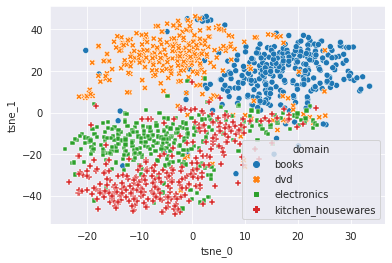

In [116]:
sns.scatterplot(data=df[df['model']=='distilbert-base-uncased'], x="tsne_0", y="tsne_1", hue="domain", style="domain")

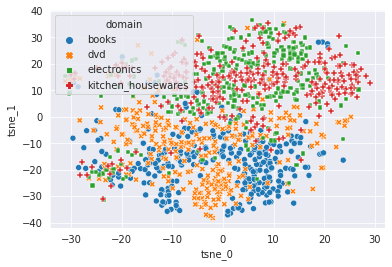

In [117]:
sns.scatterplot(data=df[df['model']=='bert-base-uncased'], x="tsne_0", y="tsne_1", hue="domain", style="domain")

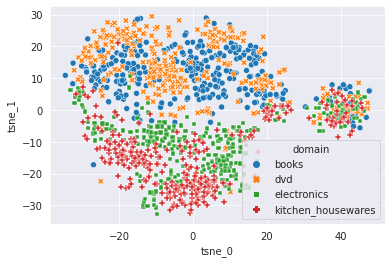

In [118]:
sns.scatterplot(data=df[df['model']=='roberta-base'], x="tsne_0", y="tsne_1", hue="domain", style="domain")

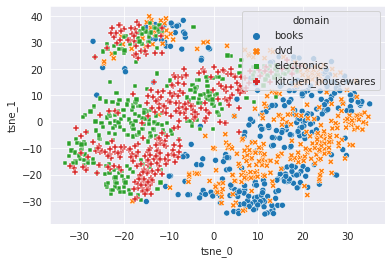

In [119]:
sns.scatterplot(data=df[df['model']=='distilroberta-base'], x="tsne_0", y="tsne_1", hue="domain", style="domain")

[None, None, None, None, None, None, None, None]

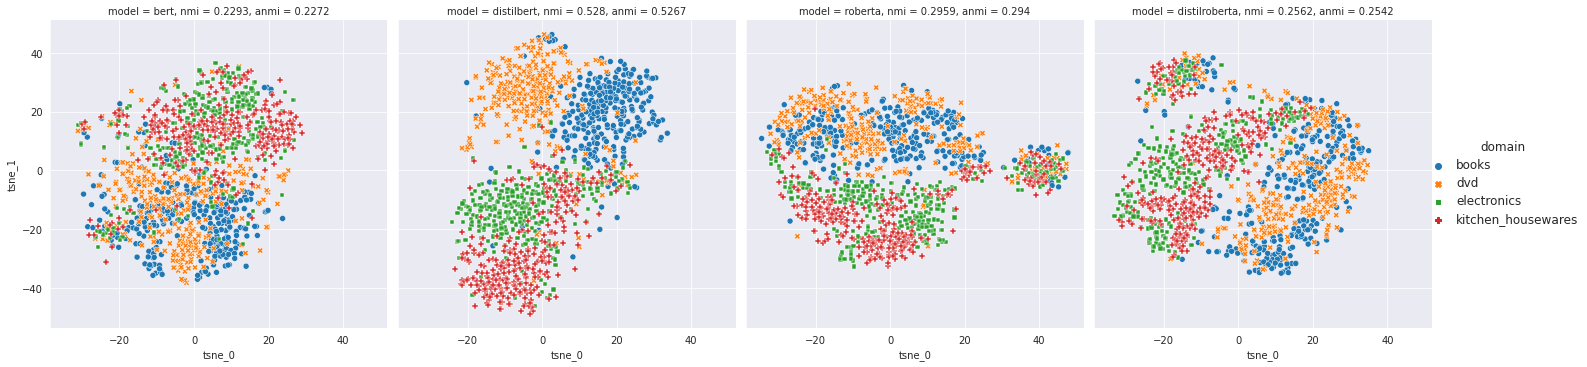

In [186]:
ax = sns.relplot(
    data=df, x="tsne_0", y="tsne_1",
    col="model", hue="domain", style="domain",
    kind="scatter"
)
plt.setp(ax._legend.get_title(), fontsize=12)
plt.setp(ax._legend.get_texts(), fontsize=12)

In [123]:
# sns.relplot(
#     data=df, x="pca_0", y="pca_1",
#     col="model", hue="domain", style="domain",
#     kind="scatter"
# )

### Compute NMI and ANMI

In [128]:
df['domain'].value_counts()

dvd                   1200
books                 1200
kitchen_housewares    1200
electronics           1200
Name: domain, dtype: int64

In [151]:
mutual_information = {

}

In [161]:
for model in tqdm(models):

    x1, x2 = df[df['model']==model]['tsne_0'].values.reshape(-1, 1), df[df['model']==model]['tsne_1'].values.reshape(-1, 1)
    x = np.concatenate((x1, x2), axis=1)
    y = df[df['model']==model]['domain'].apply(lambda domain:domain_dict[domain]).values

    kmeans = KMeans(n_clusters=4, random_state=42).fit(x)

    labels_true = y #kmeans.labels_
    labels_pred = kmeans.predict(x)

    nmi = normalized_mutual_info_score(labels_true=labels_true,  labels_pred=labels_pred)
    anmi = adjusted_mutual_info_score(labels_true=labels_true,  labels_pred=labels_pred)


    mutual_information[model] = {
        "nmi":round(nmi, 4),
        "anmi":round(anmi, 4)
    }


    




100%|██████████| 4/4 [00:00<00:00, 18.80it/s]


In [162]:
print(mutual_information)

{'bert-base-uncased': {'nmi': 0.2293, 'anmi': 0.2272}, 'distilbert-base-uncased': {'nmi': 0.528, 'anmi': 0.5267}, 'roberta-base': {'nmi': 0.2959, 'anmi': 0.294}, 'distilroberta-base': {'nmi': 0.2562, 'anmi': 0.2542}}


In [163]:
df_ = df.copy()

In [173]:
df = df_.copy()

In [174]:
df['model'] = df['model'].apply(lambda x: x.split("-")[0]+ ", nmi = " + str(mutual_information[x]['nmi']) + ", anmi = " + str(mutual_information[x]['anmi']))

In [171]:
df.head(1)

model domain     tsne_0     tsne_1     pca_0  \
0  bert, nmi = 0.2562, anmi = 0.2542  books -10.670081 -31.933619 -1.231378   

      pca_1  
0  3.963461

In [193]:
sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

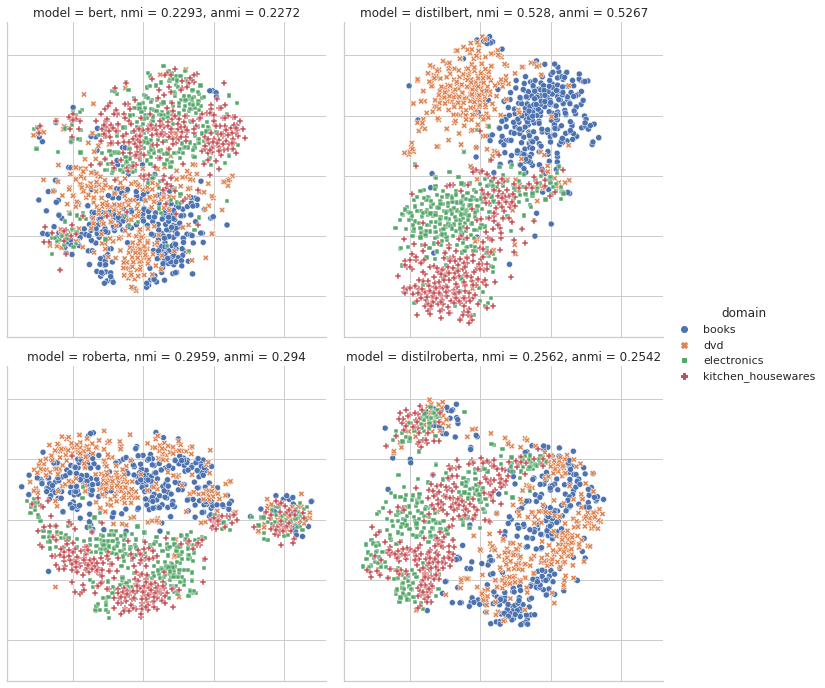

In [197]:
ax = sns.relplot(
    data=df, x="tsne_0", y="tsne_1",
    col="model", hue="domain", style="domain",
    kind="scatter",
    col_wrap=2,
    palette="deep"
)
ax.set_xlabels("")
ax.set_ylabels("")

ax.set(xticklabels=[])
ax.set(yticklabels=[])


### SST-2 vs IMDB Movie Review Analysis

In [1]:
from datasets import load_dataset
import glob as glob


In [217]:
# dataset_sst2 = load_dataset("toriving/sst2")
dataset_imdb = load_dataset("imdb")

Reusing dataset imdb (/home/macab/.cache/huggingface/datasets/imdb/plain_text/1.0.0/90099cb476936b753383ba2ae6ab2eae419b2e87f71cd5189cb9c8e5814d12a3)


In [221]:
dataset_sst2 = load_dataset('glue', 'sst2', split="validation", script_version="master")


Downloading: 28.8kB [00:00, 4.43MB/s]                   
Downloading: 28.7kB [00:00, 4.74MB/s]                   
Downloading: 100%|██████████| 7.44M/7.44M [00:02<00:00, 2.85MB/s]
Dataset glue downloaded and prepared to /home/macab/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


In [225]:
len(dataset_sst2['sentence'][0])

47

In [226]:
dataset_sst2['sentence'][0]

"it 's a charming and often affecting journey . "

In [ ]:
def sa_imdb_sst2_loader(tokenizer):

    domains = ['imdb', 'sst2']

    for domain in domains:

        if domain == "imdb":
            datasets_imdb = load_dataset("imdb")
            train = dataset_imdb['train']
            valid = dataset_imdb['valid']
            test = dataset_imdb['valid']
        else:
            



DatasetDict({'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=2, names=['neg', 'pos'], names_file=None, id=None)}, num_rows: 25000), 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=2, names=['neg', 'pos'], names_file=None, id=None)}, num_rows: 25000), 'unsupervised': Dataset(features: {'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=2, names=['neg', 'pos'], names_file=None, id=None)}, num_rows: 50000)})

In [248]:
path = os.path.join(os.getcwd(), "data", "sst2", "data")

In [251]:
glob.glob(f'{path}/*.tsv')

['/home/macab/research/robust-representation-learning/adaptil/data/sst2/data/test.tsv',
 '/home/macab/research/robust-representation-learning/adaptil/data/sst2/data/valid.tsv',
 '/home/macab/research/robust-representation-learning/adaptil/data/sst2/data/train.tsv']

In [2]:
dataset_sst2 = load_dataset("toriving/sst2")

Downloading: 100%|██████████| 1.70k/1.70k [00:00<00:00, 675kB/s]
Using custom data configuration default
Downloading: 100%|██████████| 787k/787k [00:01<00:00, 481kB/s]
Downloading: 100%|██████████| 101k/101k [00:00<00:00, 139kB/s]  
Downloading: 100%|██████████| 206k/206k [00:00<00:00, 218kB/s] 
Dataset ss_t2 downloaded and prepared to /home/macab/.cache/huggingface/datasets/ss_t2/default/0.0.0/90167692658fa4abca2ffa3ede1a43a71e2bf671078c5c275c64c4231d5a62fa. Subsequent calls will reuse this data.
/home/macab/miniconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
